# Earthquake Prediction
It is well known that if a disaster has happened in a region, it is likely to happen there again. Some regions really have frequent earthquakes, but this is just a comparative quantity compared to other regions.
So, predicting the earthquake with Date and Time, Latitude and Longitude from previous data is not a trend which follows like other things, it is natural occuring. 

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['database.csv']


In [55]:
data = pd.read_csv("../input/database.csv")
data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [56]:
data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [57]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head()

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8


In [58]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')

In [59]:
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values

In [60]:
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-1.57631e+08
1,1.863,127.352,80.0,5.8,-1.57466e+08
2,-20.579,-173.972,20.0,6.2,-1.57356e+08
3,-59.076,-23.557,15.0,5.8,-1.57094e+08
4,11.938,126.427,15.0,5.8,-1.57026e+08


## Visualization


In [61]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/opt/conda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


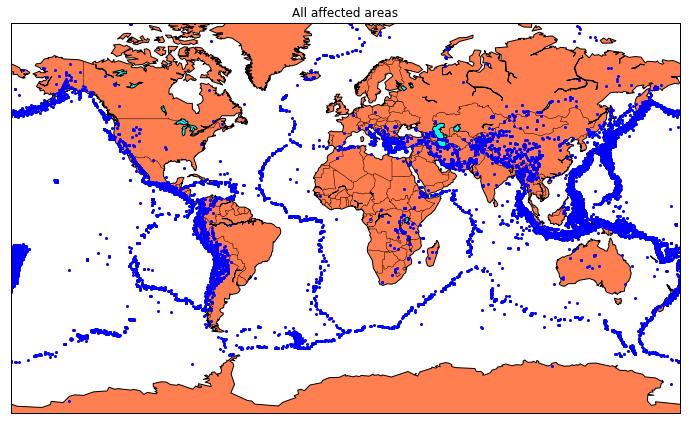

In [62]:
fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

### Splitting the Data


In [63]:
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]

In [64]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(18727, 3) (4682, 3) (18727, 2) (4682, 3)


In [65]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)
reg.predict(X_test)

array([[  5.96,  50.97],
       [  5.88,  37.8 ],
       [  5.97,  37.6 ],
       ...,
       [  6.42,  19.9 ],
       [  5.73, 591.55],
       [  5.68,  33.61]])

In [66]:
reg.score(X_test, y_test)

0.8614799631765803

In [67]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10, 20, 50, 100, 200, 500]}

grid_obj = GridSearchCV(reg, parameters)
grid_fit = grid_obj.fit(X_train, y_train)
best_fit = grid_fit.best_estimator_
best_fit.predict(X_test)

array([[  5.8888 ,  43.532  ],
       [  5.8232 ,  31.71656],
       [  6.0034 ,  39.3312 ],
       ...,
       [  6.3066 ,  23.9292 ],
       [  5.9138 , 592.151  ],
       [  5.7866 ,  38.9384 ]])

In [68]:
best_fit.score(X_test, y_test)

0.8749008584467053

### Neural Network model


In [69]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [70]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [71]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.000000 using {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
1.000000 (0.000000) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
0.000000 (0.000000) with: {'activation': 'sigmoid', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}
0.312490 (0.441945) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'SGD'}
1.000000 (0.000000) with: {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'loss': 'squared_hinge', 'neurons': 16, 'optimizer': 'Adadelta'}


In [72]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])

In [73]:
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

Train on 18727 samples, validate on 4682 samples
Epoch 1/20
18727/18727 [==============================] - 2s 125us/step - loss: 0.5000 - acc: 0.0818 - val_loss: 0.5000 - val_acc: 0.0758
Epoch 2/20
18727/18727 [==============================] - 2s 119us/step - loss: 0.5000 - acc: 0.0818 - val_loss: 0.5000 - val_acc: 0.0758
Epoch 3/20
18727/18727 [==============================] - 2s 114us/step - loss: 0.5000 - acc: 0.0818 - val_loss: 0.5000 - val_acc: 0.0758
Epoch 4/20
18727/18727 [==============================] - 2s 115us/step - loss: 0.5000 - acc: 0.0818 - val_loss: 0.5000 - val_acc: 0.0758
Epoch 5/20
18727/18727 [==============================] - 2s 127us/step - loss: 0.5000 - acc: 0.0818 - val_loss: 0.5000 - val_acc: 0.0758
Epoch 6/20
18727/18727 [==============================] - 2s 115us/step - loss: 0.5000 - acc: 0.0818 - val_loss: 0.5000 - val_acc: 0.0758
Epoch 7/20
18727/18727 [==============================] - 2s 118us/step - loss: 0.5000 - acc: 0.0818 - val_loss: 0.5000 - v

In [74]:
[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

4682/4682 [==============================] - 0s 20us/step
Evaluation result on Test Data : Loss = 0.5, accuracy = 0.07582229816636078


In [75]:
model.save('earthquake.h5')